In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import h5py
import glob 
from scipy import interpolate
import json
import os
import sys
from NuRadioReco.utilities import units
from NuRadioReco.detector import detector
from NuRadioMC.utilities import fluxes
from NuRadioMC.utilities.Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
#from my_Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
from NuRadioMC.examples.Sensitivities import E2_fluxes3 as limits
from Get_hdf5_data import get_attr_data, get_shower_data, get_station_data, get_Veff_data, get_event_data, get_nur_data
from Peak_Finding import count_peak, get_noise, save_data_2_csv, read_column_csv
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import NuRadioReco.detector.detector as detector
import NuRadioReco.modules.io.eventReader
import astropy
from NuRadioReco.framework.parameters import stationParameters as stnp
import pandas as pd
from math import isclose

temp_stdout = None
# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout


PATH = "/home/teikiet/Data/"
##########################################################################
S_ID = [100,2, 3, 4, 5] #station ID
C_ID = list(range(0,16)) #channel ID
##########################################################################
threshold = 5 #threshold
bin_size = 11 #bin size aka time interval x0.625 ns
sample_size = 800 #the time interval for peak detection x0.625ns
E = 18 #energy
num =  1e4 #number of particles
detectordescription = "detector/ara2.json" #detector 
##########################################################################
#Nur path:
inputfilename1 = PATH + f"sims_monopoles_ara2_n1.000e04_3_18to20/Nur/1.000e{E}_3"
inputfilename2 = PATH + f"sims_neutrinos_ara2_n1.000e04_3_18to20/Nur/sim_1.000e{E}.nur"
inputfilename3 = PATH + f"sims_noise_ara2_n1.000e04_1_18to18/Nur/sim_1.000e18_part02.nur"
##########################################################################
#Hdf5 path:
path1 = PATH + f'sims_monopoles_ara2_n1.000e04_3_18to20/Hdf5/1.000e{E}'
path2 = PATH + f'sims_neutrinos_ara2_n1.000e04_3_18to20/Nur/sim_1.000e{E}.hdf5'
path3 = PATH + f'sims_noise_ara2_n1.000e04_1_18to18/Hdf5/'
#get_attr_data(path2)
##########################################################################
#Save data to csv file:
data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
data2 = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e04_1e{E}.csv'
data3 = PATH + f'Peak_data/Data_noise_ara2.csv'
##########################################################################
#Find peak and save data:
#save_data_2_csv(data1, inputfilename1, detectordescription, S_ID, C_ID)  
#save_data_2_csv(data2 ,inputfilename2, detectordescription, S_ID, C_ID)  
#save_data_2_csv(data3 ,inputfilename3, detectordescription, S_ID, C_ID)

In [34]:
# Read the CSV file and get the number of triggered events:
num_MM = []
for E in [18,19,20]:
    data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
    data_frame1 = pd.read_csv(data1)
    event_id1 = np.array(data_frame1["event"])
    num_of_events_1 = event_id1[-1]
    num_MM.append(num_of_events_1)
    print("Number of events in monopoles: ", num_of_events_1)

Number of events in monopoles:  67.0
Number of events in monopoles:  98.0
Number of events in monopoles:  196.0


In [2]:
num_MM = [ 67.,  98., 196.]
num_MM = np.array(num_MM)
print(num_MM)

[ 67.  98. 196.]


In [36]:
#######################################################
#Counting em shower and hadronic shower (ALL SHOWER PRODUCED BY MONOPOLES):
E2 = [18, 19, 20]
num_em = []
num_had = []
num_total = []
for e in E2:
    hdf5 = PATH + f"sims_monopoles_ara2_n1.000e04_3_18to20/Hdf5/1.000e{e}"
    shower_id, shower_energies, xx, yy, zz, shower_type, triggered = get_shower_data(hdf5)
    em = 0
    had = 0
    trig_i = 0
    for i_s in shower_type:
        if triggered[trig_i] == 1:
            i_s = str(i_s)
            if i_s == "b'em'":
                em += 1
            elif i_s == "b'had'":
                had += 1
            else:
                print(i_s, type(i_s))
        trig_i += 1
    num_em.append(em)
    num_had.append(had)
    num_total.append(em + had)
    print("Energy: 1e", e)
    print("Number of em shower:", em)
    print("Number of hadronic shower:", had)
    print("Total number of shower:", em + had)
    print("Percentage of em shower:", em/(em + had))

num_em = np.array(num_em)/num_MM
num_had = np.array(num_had)/num_MM
num_total = np.array(num_total)/num_MM

Energy: 1e 18
Number of em shower: 439
Number of hadronic shower: 5891
Total number of shower: 6330
Percentage of em shower: 0.0693522906793049
Energy: 1e 19
Number of em shower: 6354
Number of hadronic shower: 31324
Total number of shower: 37678
Percentage of em shower: 0.16863952439089125
Energy: 1e 20
Number of em shower: 300909
Number of hadronic shower: 139538
Total number of shower: 440447
Percentage of em shower: 0.6831900319448196


In [41]:
num_em, num_had, num_total

(array([   6.55223881,   64.83673469, 1535.25      ]),
 array([ 87.92537313, 319.63265306, 711.92857143]),
 array([  94.47761194,  384.46938776, 2247.17857143]))

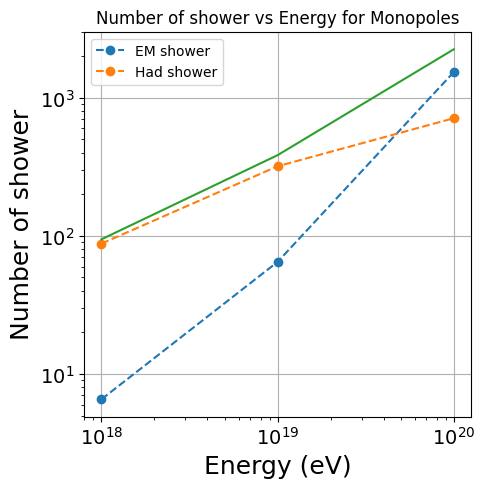

In [3]:
#Monopoles:
E = [1e18, 1e19, 1e20]
num_em = [   6.55223881,   64.83673469, 1535.25 ]
num_had = [ 87.92537313, 319.63265306, 711.92857143]
num_total = [ 94.47761194, 384.46938776, 2247.17857143]
plt.figure(figsize=(5, 5))
plt.plot(E, num_em, "o--", label="EM shower")
plt.plot(E, num_had, "o--", label="Had shower")
plt.plot(E, num_total)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Number of shower")
plt.title("Number of shower vs Energy for Monopoles")
plt.grid()
plt.show()


In [15]:
#Get the triggered shower data:
# Read the CSV file
E = 19
data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
path1 = PATH + f'sims_monopoles_ara2_n1.000e04_3_18to20/Hdf5/1.000e{E}'
data_frame1 = pd.read_csv(data1)
event_id1 = np.array(data_frame1["event"])
num_of_events_1 = event_id1[-1]

####################
e_id1 = list(range(1, int(event_id1[-1]+1)))
####################
S_ID = [100, 2, 3, 4, 5] #station ID
s_ID1 = S_ID
####################
c_ID1 = C_ID

# Access a specific column by column name using indexing operator 
#trace1 = np.array(data_frame1.query(f"station == {s_ID1} and channel == {c_ID1} and event == {e_id1}")['Traces']) 
#times1 = np.array(data_frame1.query(f"station == {s_ID1} and channel == {c_ID1} and event == {e_id1}")['Times'])

total_event1 = event_id1[-1]
print(total_event1)
#amp_time1, max_amp1, distance1, shower_id1 = get_station_data(path1, s_ID1, c_ID1)

98.0


In [16]:
shower_id_per_station = []
for s_ID1 in S_ID:
    _, max_amp1, _, shower_id1 = get_station_data(path1, [s_ID1], c_ID1)
    noise1=1.0661514487245143e-05
    snr_shower1 = max_amp1/noise1 #calculate the snr
    triggered_shower = []
    for i in range(len(snr_shower1)):
        if snr_shower1[i] >= 5: #check if the shower pass the thresshold
            triggered_shower.append(shower_id1[i])
    values, counts = np.unique(triggered_shower, return_counts=True)
    shower_id_per_station.append(values)
    print(len(values))
    num_triggered_shower = len(values)
    print(f"Number of triggered shower per event for {s_ID1}:", num_triggered_shower/total_event1)

Finish!
122
Number of triggered shower per event for 100: 1.2448979591836735
Finish!
465
Number of triggered shower per event for 2: 4.744897959183674
Finish!
556
Number of triggered shower per event for 3: 5.673469387755102
Finish!
671
Number of triggered shower per event for 4: 6.846938775510204
Finish!
812
Number of triggered shower per event for 5: 8.285714285714286


In [21]:
(1+5+6+7+8)/5

5.4

In [17]:
print(shower_id_per_station)

[array([2476518., 2476582., 2476602., 2476610., 2476622., 2476628.,
       2476632., 3119669., 3119677., 3119681., 3119683., 3119687.,
       3119695., 3119703., 3119705., 3119707., 3119711., 3119715.,
       3119723., 3119727., 3119729., 3119731., 3119737., 3119741.,
       3119743., 3119747., 3119749., 3119751., 3119755., 3119757.,
       3119759., 3119775., 3119785., 3119791., 3119797., 3119799.,
       3119811., 3119821., 3119827., 3119835., 3119839., 3119843.,
       3119859., 3119863., 3119865., 3119867., 3119871., 3119873.,
       3119891., 3119895., 3119905., 3119911., 3119923., 4401450.,
       4401452., 4401458., 4401462., 4401472., 4401482., 4401486.,
       4401488., 4401494., 4401496., 4401498., 4401500., 4401510.,
       4401512., 4401514., 4401516., 4401518., 4401524., 4401526.,
       4401528., 4401548., 4401550., 4401554., 4401556., 4401568.,
       4401570., 4401574., 4401580., 4401598., 4401602., 4401612.,
       4401624., 4401632., 4401634., 4401652., 4401664., 4401

In [18]:
s = []
for i in range(len(shower_id_per_station)):
    for j in range(len(shower_id_per_station[i])):
        s.append(int(shower_id_per_station[i][j]))
values, counts = np.unique(s, return_counts=True)
print(values, counts)

[   8861    8877    8879 ... 5993214 5993236 5993242] [1 1 1 ... 1 1 1]


In [20]:
sum(counts), len(counts)

(2626, 2626)

In [102]:
noise1=1.0661514487245143e-05
snr_shower1 = max_amp1/noise1
triggered_shower = []
for i in range(len(snr_shower1)):
    if snr_shower1[i] >= 5:
        triggered_shower.append(shower_id1[i])
values, counts = np.unique(triggered_shower, return_counts=True)
print(len(values))
num_triggered_shower = len(values)
print("Number of triggered shower per event:", num_triggered_shower/total_event1)

9748
Number of triggered shower per event: 49.734693877551024


In [100]:
len(snr_shower1)

602848

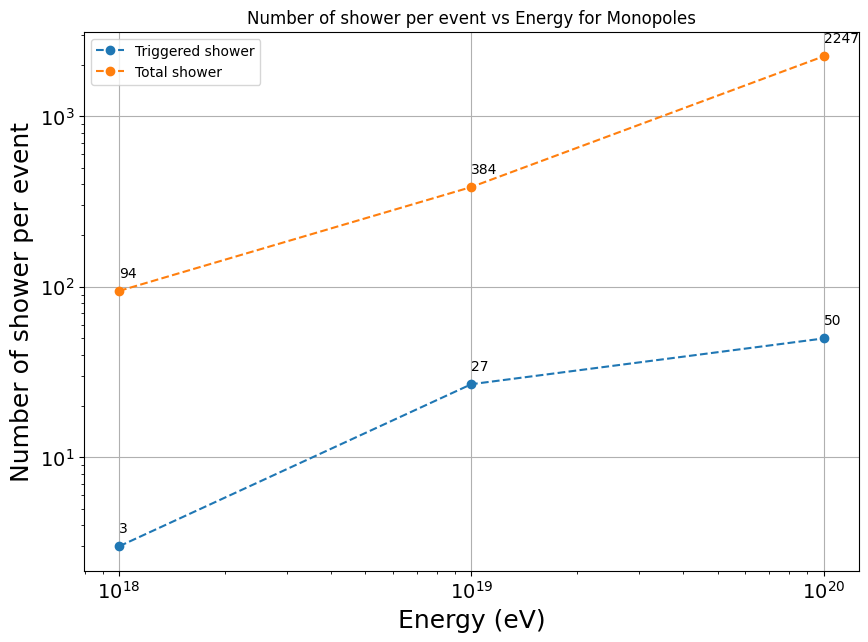

In [126]:
E = [1e18, 1e19, 1e20]
trig_shower_per_event = [3, 26.80, 49.73]
num_total = [ 94.47761194, 384.46938776, 2247.17857143]

#adding value to the plot:
plt.figure(figsize=(10, 7))
for i in range(len(E)):
    plt.text(E[i], trig_shower_per_event[i]*1.2, str(round(trig_shower_per_event[i])))
    plt.text(E[i], num_total[i]*1.2, str(round(num_total[i])))
plt.plot(E, trig_shower_per_event, "o--", label="Triggered shower")
plt.plot(E, num_total, "o--", label="Total shower")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Number of shower per event")
plt.title("Number of shower per event vs Energy for Monopoles")
plt.grid()
plt.show()



In [128]:
#detector efficiency:
trig_shower_per_event = np.array(trig_shower_per_event)
num_total = np.array(num_total)
efficiency = trig_shower_per_event/num_total
print(efficiency*100)

[3.17535545 6.970646   2.21299725]


/home/teikiet/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


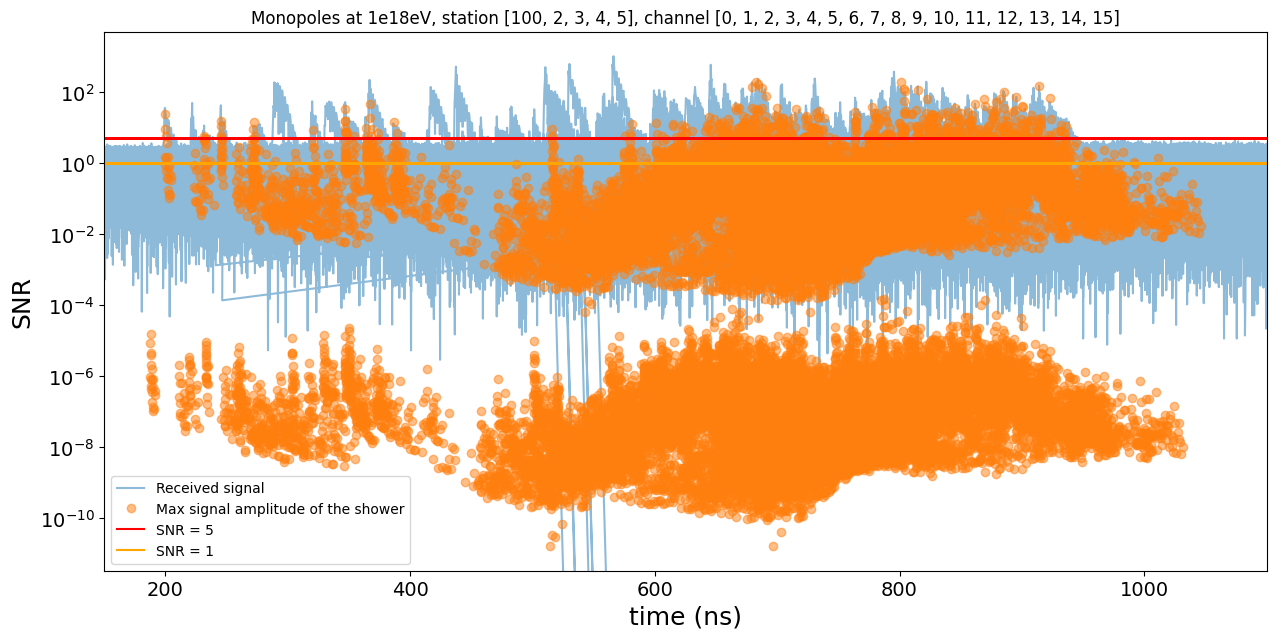

In [47]:
#Monopoles signal plot:
dt = 0.625#ns
plt.figure(figsize=(15, 7))
noise1=1.0661514487245143e-05
#plt.plot(t_bin1*dt, v_bin1/noise1, "-", label = "Received signal")
plt.plot(times1*dt, abs(trace1)/noise1,"-" ,alpha = 0.5, label = "Received signal")
plt.plot(amp_time1*dt, max_amp1/noise1, "o",alpha = 0.5, label = "Max signal amplitude of the shower")

plt.plot(times1*dt, threshold+times1*0, "-", label = f"SNR = {threshold}", color = "red")
plt.plot(times1*dt, 1+times1*0, "-", label = "SNR = 1", color = "orange")
#plt.xlim(min(t_bin1*dt), max(t_bin1*dt))
#plt.ylim(5e-1, max( V_peak1/noise1)*1.5)
plt.title(f"Monopoles at 1e{E}eV, station {s_ID1}, channel {c_ID1}")
plt.legend()
plt.ylabel("SNR")
plt.xlabel("time (ns)")
plt.yscale("log")
#plt.ylim(1e-9, 1e-1)
plt.xlim(150, 1100)
plt.show()

In [43]:
#Counting triggered events:
def get_nur_event_from_file(inputfilename, detectordescription, e_id):
    # read in detector positions 
    print("Read file:", inputfilename)
    det = detector.Detector(json_filename=detectordescription)

        # initialize modules
    eventReader = NuRadioReco.modules.io.eventReader.eventReader()
    eventReader.begin(inputfilename)
    detector_time = astropy.time.Time('2040-01-01 20:00:00')
    det.update(detector_time)
    #event_id = np.array([])
    for event in eventReader.run():
        print("Get data for event: ",e_id)
        e_id += 1
        for Shower in event.get_sim_showers():
            print(Shower)


def get_nur_event(inputfilename, detectordescription, e_id):
    print("Read file:", inputfilename)

inputfilename = PATH + f"sims_neutrinos_ara2_n1.000e04_3_18to20/Nur/sim_1.000e18.nur"
get_nur_event_from_file(inputfilename, detectordescription, 1)

Read file: /home/teikiet/Data/sims_neutrinos_ara2_n1.000e04_3_18to20/Nur/sim_1.000e18.nur
Get data for event:  1
Get data for event:  2
Get data for event:  3
Get data for event:  4
Get data for event:  5
Get data for event:  6
Get data for event:  7
Get data for event:  8
Get data for event:  9
Get data for event:  10
Get data for event:  11
Get data for event:  12
Get data for event:  13
Get data for event:  14
Get data for event:  15
Get data for event:  16
Get data for event:  17
Get data for event:  18
Get data for event:  19
Get data for event:  20
Get data for event:  21
Get data for event:  22
Get data for event:  23
Get data for event:  24
Get data for event:  25
Get data for event:  26
Get data for event:  27
Get data for event:  28
Get data for event:  29
Get data for event:  30
Get data for event:  31
Get data for event:  32
Get data for event:  33
Get data for event:  34
Get data for event:  35
Get data for event:  36
Get data for event:  37
Get data for event:  38
Get dat